# Preprocess Data

In [1]:
#!pip install gensim --upgrade
#!pip install keras --upgrade
#!pip install pandas --upgrade
#!pip install Keras-Preprocessing

In [2]:
import tensorflow as tf
print(tf.__version__)

C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


2.16.1


In [3]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kwfen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [5]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [6]:
file_path = '../../archive/training.1600000.processed.noemoticon.csv'
df = pd.read_csv(file_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [7]:
df.shape

(1600000, 6)

In [8]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [9]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [10]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: total: 109 ms
Wall time: 274 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

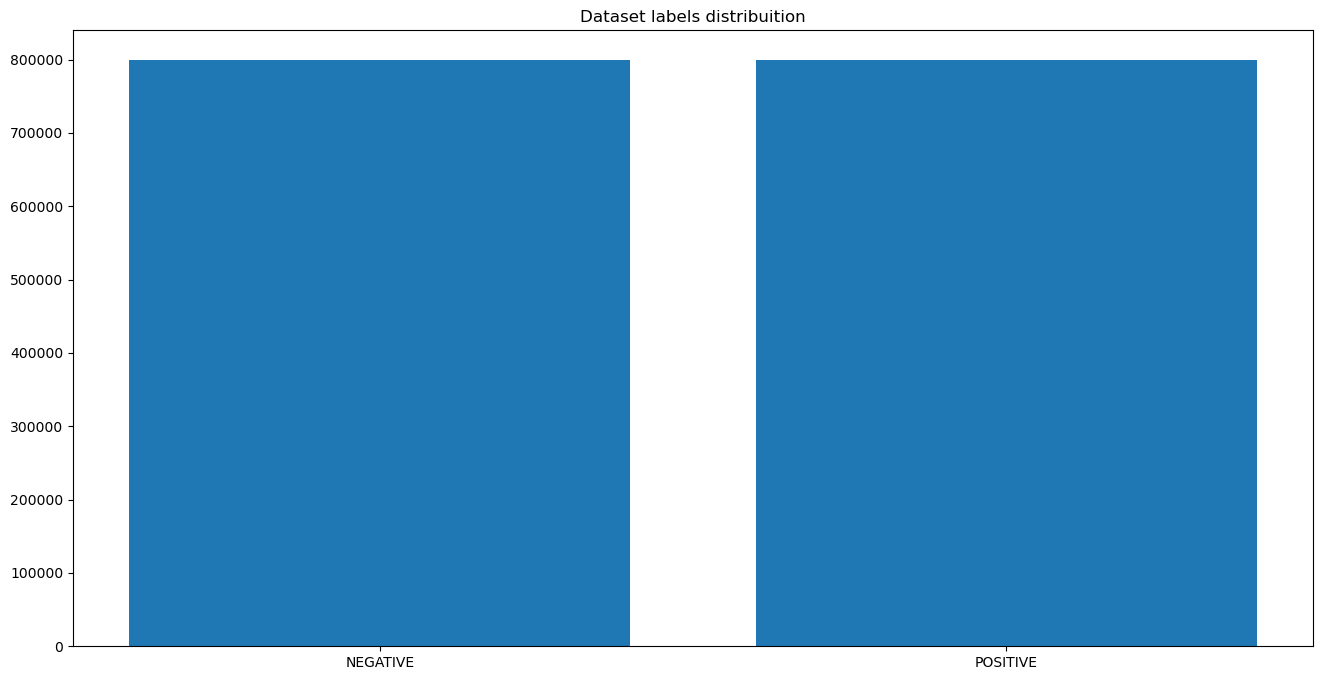

In [11]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [12]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [13]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [14]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: total: 17 s
Wall time: 29.1 s


### Split train and test

In [15]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [16]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: total: 2.64 s
Wall time: 3.51 s


In [17]:
W2V_SIZE = 100
W2V_WINDOW = 5
W2V_MIN_COUNT = 1
W2V_WORKERS = 8
w2v_model = gensim.models.Word2Vec(vector_size=W2V_SIZE, 
                                   window=W2V_WINDOW, 
                                   min_count=W2V_MIN_COUNT, 
                                   workers=W2V_WORKERS)

2024-06-14 10:09:39,858 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.025>', 'datetime': '2024-06-14T10:09:39.858379', 'gensim': '4.3.2', 'python': '3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'created'}


In [18]:
w2v_model.build_vocab(documents)

2024-06-14 10:09:39,878 : INFO : collecting all words and their counts
2024-06-14 10:09:39,878 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-06-14 10:09:39,887 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2024-06-14 10:09:39,897 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2024-06-14 10:09:39,911 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2024-06-14 10:09:39,920 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2024-06-14 10:09:39,930 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2024-06-14 10:09:39,939 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2024-06-14 10:09:39,953 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2024-06-14 10:09:39,962 : INFO : PROGRESS: at s

2024-06-14 10:09:40,720 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2024-06-14 10:09:40,730 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2024-06-14 10:09:40,741 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2024-06-14 10:09:40,753 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2024-06-14 10:09:40,764 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2024-06-14 10:09:40,771 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2024-06-14 10:09:40,785 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2024-06-14 10:09:40,796 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2024-06-14 10:09:40,805 : INFO : PROGRESS: at sentence #800000, processed 577088

In [19]:
# Get the keys from the model's dictionary (the vocabulary)
words = w2v_model.wv.index_to_key

# Calculate vocabulary size
vocab_size = len(words)

print("Vocabulary size:", vocab_size)

Vocabulary size: 290418


In [20]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2024-06-14 10:13:58,108 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 290418 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5 shrink_windows=True', 'datetime': '2024-06-14T10:13:58.108380', 'gensim': '4.3.2', 'python': '3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'train'}
2024-06-14 10:13:59,132 : INFO : EPOCH 0 - PROGRESS: at 37.59% examples, 3268146 words/s, in_qsize 15, out_qsize 0
2024-06-14 10:14:00,139 : INFO : EPOCH 0 - PROGRESS: at 75.13% examples, 3259708 words/s, in_qsize 15, out_qsize 0
2024-06-14 10:14:00,776 : INFO : EPOCH 0: training on 9227204 raw words (8708475 effective words) took 2.6s, 3291930 effective words/s
2024-06-14 10:14:01,791 : INFO : EPOCH 1 - PROGRESS: at 38.13% examples, 3317877 words/s, in_qsize 13, out_qsize 2
2024-06-14 10:14:02,793 : INFO : EPOCH 1 - PROGRESS: at 74.59% examples, 3244229 wor

2024-06-14 10:14:56,665 : INFO : EPOCH 21 - PROGRESS: at 74.27% examples, 3222701 words/s, in_qsize 16, out_qsize 0
2024-06-14 10:14:57,389 : INFO : EPOCH 21: training on 9227204 raw words (8707479 effective words) took 2.7s, 3187282 effective words/s
2024-06-14 10:14:58,400 : INFO : EPOCH 22 - PROGRESS: at 34.78% examples, 3026181 words/s, in_qsize 15, out_qsize 0
2024-06-14 10:14:59,405 : INFO : EPOCH 22 - PROGRESS: at 71.99% examples, 3127739 words/s, in_qsize 14, out_qsize 1
2024-06-14 10:15:00,166 : INFO : EPOCH 22: training on 9227204 raw words (8708901 effective words) took 2.8s, 3146647 effective words/s
2024-06-14 10:15:01,180 : INFO : EPOCH 23 - PROGRESS: at 34.35% examples, 2988391 words/s, in_qsize 16, out_qsize 0
2024-06-14 10:15:02,178 : INFO : EPOCH 23 - PROGRESS: at 72.10% examples, 3124860 words/s, in_qsize 15, out_qsize 0
2024-06-14 10:15:02,958 : INFO : EPOCH 23: training on 9227204 raw words (8708847 effective words) took 2.8s, 3134040 effective words/s
2024-06-14 1

CPU times: total: 49 s
Wall time: 1min 26s


(278680467, 295270528)

In [21]:
# Find the most similar words to a given word
similar_words = w2v_model.wv.most_similar("love")

# Print the similar words
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

loves: 0.6678182482719421
luv: 0.6586138010025024
loved: 0.6231092214584351
adore: 0.6132185459136963
amazing: 0.5870189070701599
awesome: 0.5724228024482727
loooove: 0.5348321199417114
looooove: 0.5262219905853271
loving: 0.5255035161972046
fav: 0.5020535588264465


### Tokenize Text

In [22]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: total: 4.19 s
Wall time: 9.16 s


In [30]:
num_words = len(tokenizer.word_index)
print(f'Number of unique words: {num_words}')

Number of unique words: 290418


In [23]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: total: 5.92 s
Wall time: 13.6 s


In [31]:
x_train

array([[   0,    0,    0, ...,  712,  118, 4999],
       [   0,    0,    0, ...,  452,  378, 4999],
       [   0,    0,    0, ..., 2048,    4, 4999],
       ...,
       [   0,    0,    0, ...,  661, 4246, 4999],
       [   0,    0,    0, ...,   12,  477,  957],
       [   0,    0,    0, ...,    9,  502,  268]])

### Label Encoder 

In [24]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [25]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [26]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [29]:
def check_and_fix_out_of_bounds(x_train, max_value):
    num_out_of_bounds = np.sum(x_train >= max_value)
    print(f"Number of out-of-bounds values: {num_out_of_bounds}")
    x_train[x_train >= max_value] = max_value - 1
    return x_train

x_train = check_and_fix_out_of_bounds(x_train, 5000)

Number of out-of-bounds values: 1421709


### Dump x_train, x_test, y_train, y_test to files

In [28]:
# Assuming x_train, y_train, x_test, and y_test are your numpy arrays
folder = 'input/'
np.save('input/x_train.npy', x_train)
np.save('input/y_train.npy', y_train)
np.save('input/x_test.npy', x_test)
np.save('input/y_test.npy', y_test)